# Prophet을 통한 outlier 채워넣기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
train = pd.read_csv('./data/train.csv')
#b_keyword = pd.read_csv('./data/brand_keyword_cnt.csv')
sales = pd.read_csv('./data/sales.csv')
#prd_info = pd.read_csv('./data/product_info.csv')

In [4]:
train

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,15887,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,B002-03799-00005,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [17]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import numpy as np
RANDOM_SEED = 990313
np.random.seed(RANDOM_SEED)

/Users/adam_ham/anaconda3/envs/aiffel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
train.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
t = train.iloc[:,:422]
t

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-02-11,2023-02-12,2023-02-13,2023-02-14,2023-02-15,2023-02-16,2023-02-17,2023-02-18,2023-02-19,2023-02-20
0,0,B002-00001-00001,1,6,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,2,7,43,1,0,0,0,0,...,1,1,2,2,2,2,2,0,0,0
2,2,B002-00002-00002,2,7,43,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,2,7,43,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,0,0,2,2,0,0,0,0,...,13,0,5,1,12,8,0,10,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,B002-03799-00002,2,7,41,3169,0,0,0,0,...,123,154,35,35,1,0,0,0,2,3
15886,15886,B002-03799-00003,2,7,43,3169,0,0,0,0,...,6,8,10,9,8,68,105,123,81,38
15887,15887,B002-03799-00004,2,7,43,3169,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,B002-03799-00005,2,7,43,3169,0,0,0,0,...,2,2,1,0,0,2,2,0,0,0


In [35]:
def ph_train(df):
    pred_list = []  
    for code in df['ID'].unique():
        d = df[df['ID'] == code].reset_index().drop(['index','ID','제품'], axis=1)
        df_transposed = d.melt(id_vars=['대분류', '중분류', '소분류', '브랜드'], var_name='ds', value_name='y')
        # Convert 'ds' column to datetime
        df_transposed['ds'] = pd.to_datetime(df_transposed['ds'])

        # Drop unnecessary columns
        df_transposed.drop(columns=['대분류', '중분류', '소분류', '브랜드'], inplace=True)
        #print(df_transposed)
        
        #.sort_values('ds')
        model = Prophet(#growth = 'choose',seasonality_mode = 'choose',yearly_seasonality = 'choose',weekly_seasonality = 'choose',daily_seasonality = 'choose',holidays = 'choose'
                       )
        model.fit(df_transposed)
        future = pd.DataFrame()
        future['ds'] = pd.date_range(start='2023-02-21', periods=40)#, freq='choose') 
        forecast = model.predict(future)        
        pred_y = forecast['yhat'].values
        pred_code = [str(code)] * len(pred_y)
        for y_val, id_val in zip(pred_y, pred_code):
            pred_list.append({'ID': id_val, 'y': y_val})
    pred = pd.DataFrame(pred_list) 
    return pred
pred = ph_train(t)
pred

23:29:26 - cmdstanpy - INFO - Chain [1] start processing
23:29:26 - cmdstanpy - INFO - Chain [1] done processing
23:29:26 - cmdstanpy - INFO - Chain [1] start processing
23:29:26 - cmdstanpy - INFO - Chain [1] done processing
23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing
23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1]

,ID,y
0,0,2.786699
1,0,3.183400
2,0,3.055963
3,0,3.080680
4,0,2.648530
...,...,...
635595,15889,-0.005612
635596,15889,-0.005608
635597,15889,-0.005604
635598,15889,0.011373


In [36]:
pred

,ID,y
0,0,2.786699
1,0,3.183400
2,0,3.055963
3,0,3.080680
4,0,2.648530
...,...,...
635595,15889,-0.005612
635596,15889,-0.005608
635597,15889,-0.005604
635598,15889,0.011373


In [53]:
# Create an empty matrix of size 15889x40 filled with zeros
matrix = np.zeros((15890, 40),dtype=np.float64)
# Group the DataFrame by 'ID' and aggregate the values of 'y'
grouped = pred.groupby('ID')['y'].apply(list)
# Fill the matrix with the aggregated values of 'y' for each ID
for idx, values in grouped.items():
    matrix[int(idx), :40] = np.round(values,4)

In [56]:
new = pd.DataFrame(matrix)

In [74]:
new = new.rename(dict(zip(new.columns,date_list)),axis=1)

In [73]:
# Define the start date
start_date = '2023-02-21'

# Convert the start date to a datetime object
start_date = pd.to_datetime(start_date)

# Generate a sequence of dates starting from the start date and extending by 40 days
date_range = pd.date_range(start=start_date, periods=40)

# Convert the date_range to strings with the format 'YYYY-MM-DD'
date_strings = date_range.strftime('%Y-%m-%d')

# Convert the date_strings to a list
date_list = date_strings.tolist()

# Print the list of dates as strings
print(date_list)

['2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25', '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-01']


In [78]:
new

,2023-02-21,2023-02-22,2023-02-23,2023-02-24,2023-02-25,2023-02-26,2023-02-27,2023-02-28,2023-03-01,2023-03-02,...,2023-03-23,2023-03-24,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01
0,2.7867,3.1834,3.0560,3.0807,2.6485,2.5732,2.5810,2.8837,3.2804,3.1530,...,3.4441,3.4688,3.0367,2.9614,2.9692,3.2719,3.6686,3.5412,3.5659,3.1337
1,0.3278,0.4629,0.7335,0.9363,0.8001,0.5494,0.3489,0.3374,0.4725,0.7431,...,0.7719,0.9746,0.8384,0.5877,0.3873,0.3758,0.5109,0.7815,0.9842,0.8480
2,-0.4433,-0.7335,-0.5999,-0.5509,-0.2365,-0.4391,-0.4914,-0.5839,-0.8742,-0.7406,...,-1.1625,-1.1135,-0.7991,-1.0018,-1.0540,-1.1465,-1.4368,-1.3032,-1.2542,-0.9397
3,-0.6338,-1.6619,-1.4685,-1.8518,-0.9488,-0.9091,-1.1861,-0.8228,-1.8508,-1.6574,...,-2.2243,-2.6076,-1.7046,-1.6648,-1.9419,-1.5786,-2.6066,-2.4132,-2.7965,-1.8935
4,4.1697,4.3239,4.9866,6.5645,6.0182,4.8865,3.8714,4.2424,4.3966,5.0593,...,5.2775,6.8555,6.3092,5.1775,4.1624,4.5334,4.6876,5.3503,6.9282,6.3819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,17.4002,16.7551,21.3482,26.2804,31.5047,34.2215,26.2509,17.7598,17.1147,21.7078,...,22.7866,27.7188,32.9431,35.6599,27.6893,19.1982,18.5531,23.1462,28.0784,33.3027
15886,19.6738,21.2715,22.6646,22.7359,23.2057,22.1449,21.1340,20.9173,22.5150,23.9081,...,27.6386,27.7099,28.1796,27.1188,26.1080,25.8913,27.4889,28.8821,28.9534,29.4231
15887,-1.5851,-1.2629,-0.7204,-0.4153,-1.1662,-1.4700,-1.3218,-1.7316,-1.4094,-0.8669,...,-1.3063,-1.0012,-1.7520,-2.0559,-1.9077,-2.3174,-1.9953,-1.4527,-1.1477,-1.8985
15888,-0.7501,-0.4930,0.0356,0.2421,0.1267,-0.2709,-0.7186,-0.9462,-0.6891,-0.1605,...,-0.7489,-0.5424,-0.6578,-1.0554,-1.5031,-1.7307,-1.4736,-0.9450,-0.7385,-0.8539


In [95]:
final = pd.concat([train.iloc[:,:422],new],axis=1)

In [96]:
final = final.drop(['ID','제품'],axis=1)

In [97]:
final

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-23,2023-03-24,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01
0,1,6,37,0,0,0,0,0,0,0,...,3.4441,3.4688,3.0367,2.9614,2.9692,3.2719,3.6686,3.5412,3.5659,3.1337
1,2,7,43,1,0,0,0,0,0,0,...,0.7719,0.9746,0.8384,0.5877,0.3873,0.3758,0.5109,0.7815,0.9842,0.8480
2,2,7,43,1,0,0,0,0,0,0,...,-1.1625,-1.1135,-0.7991,-1.0018,-1.0540,-1.1465,-1.4368,-1.3032,-1.2542,-0.9397
3,2,7,43,1,0,0,0,0,0,0,...,-2.2243,-2.6076,-1.7046,-1.6648,-1.9419,-1.5786,-2.6066,-2.4132,-2.7965,-1.8935
4,0,0,2,2,0,0,0,0,0,0,...,5.2775,6.8555,6.3092,5.1775,4.1624,4.5334,4.6876,5.3503,6.9282,6.3819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,2,7,41,3169,0,0,0,0,0,0,...,22.7866,27.7188,32.9431,35.6599,27.6893,19.1982,18.5531,23.1462,28.0784,33.3027
15886,2,7,43,3169,0,0,0,0,0,0,...,27.6386,27.7099,28.1796,27.1188,26.1080,25.8913,27.4889,28.8821,28.9534,29.4231
15887,2,7,43,3169,0,0,0,0,0,0,...,-1.3063,-1.0012,-1.7520,-2.0559,-1.9077,-2.3174,-1.9953,-1.4527,-1.1477,-1.8985
15888,2,7,43,3169,0,0,0,0,0,0,...,-0.7489,-0.5424,-0.6578,-1.0554,-1.5031,-1.7307,-1.4736,-0.9450,-0.7385,-0.8539


,대분류,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,2022-01-11,...,2023-03-23,2023-03-24,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01
0,0,57336,54769,66988,75390,85298,103458,109806,102022,65511,...,75833.0112,79090.4789,74984.5024,67129.4511,56630.1410,53502.1216,64183.1817,75515.4762,78772.9453,74666.9599
1,1,78236,82917,104607,117228,113833,95617,96289,85339,83802,...,207734.6563,230458.0278,203213.1931,175149.1414,143862.8804,134132.5384,162314.2527,206727.9890,229451.3615,202206.5373
2,2,17,16,19,24,24,32,33,32,23,...,3198.4173,3389.8276,3232.4886,2963.7373,2663.3404,2564.0065,2818.0533,3210.4328,3401.8425,3244.5037
3,3,3,9,12,10,13,15,11,8,13,...,-50.9227,-37.1025,-68.4700,-117.5049,-134.1880,-138.1095,-95.0283,-59.9190,-46.0980,-77.4663
4,4,7626,8333,6409,5755,6339,4788,5626,4071,4016,...,13265.8024,14169.9178,12525.8049,10807.3433,9307.8705,8886.1518,11115.3039,13204.0929,14108.2084,12464.0949


5
0    0
1    1
2    2
3    3
4    4
Name: 대분류, dtype: int64


<Axes: >

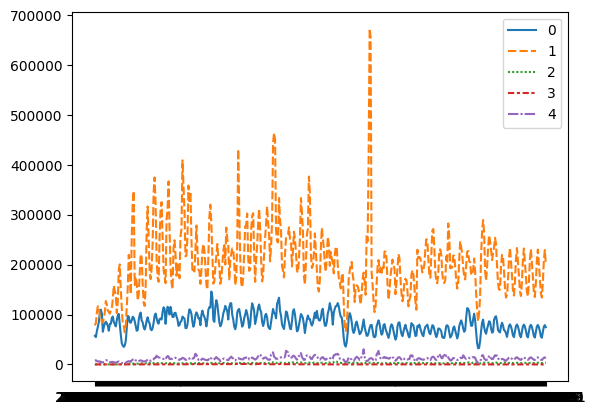

In [101]:
date = final.columns[6:]
date
sell_per_Large = final.groupby(['대분류']).sum()[date]
sell_per_Large = sell_per_Large.reset_index()
display(sell_per_Large.head())
print(len(sell_per_Large))

name_large = sell_per_Large['대분류']
print(name_large)
temp = sell_per_Large.T.iloc[1:]
temp.head()

temp = temp.rename(columns=dict(zip(temp.columns, name_large)))

sns.lineplot(temp)

,중분류,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,2022-01-11,...,2023-03-23,2023-03-24,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01
0,0,56233,53584,65530,73783,83867,102257,108720,101013,64430,...,73152.3501,76289.1458,72330.4036,64720.5645,54529.9529,51495.1237,61897.9154,72847.0630,75983.8596,72025.1099
1,1,2045,2110,2618,2799,2856,2479,2418,2117,2043,...,3934.6645,4429.8275,3556.8296,1560.6525,378.9106,-70.6497,1288.1512,3461.4596,3956.6241,3083.6271
2,2,5499,5328,6329,7045,6572,5299,5238,4933,4839,...,10021.9054,9935.7249,8850.8066,7727.5022,7040.6919,6995.0652,8308.7085,9879.0736,9792.8900,8707.9761
3,3,5519,6115,8285,9338,9045,7677,6940,6234,6166,...,31655.3169,31832.6193,29802.3462,27454.7785,26116.4791,25926.5142,29268.8058,31872.7688,32050.0702,30019.7995
4,4,50808,53050,66268,74396,72573,58748,60729,52791,51276,...,121370.7726,141809.3658,120541.4815,102210.0991,77869.1892,69683.3735,87636.0369,120504.1724,140942.7681,119674.8845


11
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
Name: 중분류, dtype: int64


<Axes: >

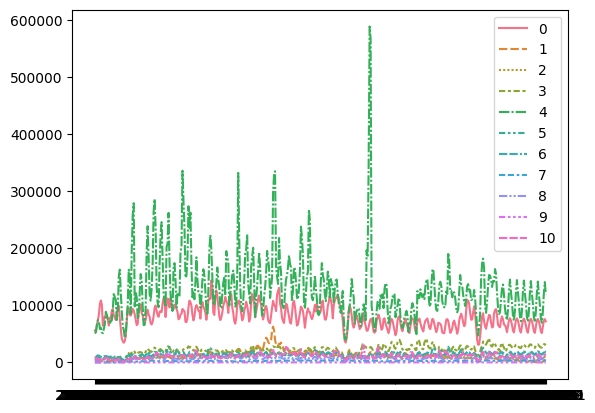

In [112]:
sell_per_Large = final.groupby(['중분류']).sum()[date]
sell_per_Large = sell_per_Large.reset_index()
display(sell_per_Large.head())
print(len(sell_per_Large))

name_large = sell_per_Large['중분류']
print(name_large)
temp = sell_per_Large.T.iloc[1:]
temp.head()

temp = temp.rename(columns=dict(zip(temp.columns, name_large)))

sns.lineplot(temp)

,소분류,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,2022-01-11,...,2023-03-23,2023-03-24,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01
0,0,6410,7237,10756,14396,16040,11582,10227,7887,6875,...,7185.9403,7689.0559,6825.3334,5785.2048,4437.0034,4201.1624,5622.3634,6920.1869,7423.3025,6559.5775
1,1,6167,6303,7987,9195,9575,8381,8153,6876,6690,...,8498.1719,8652.5108,7889.8235,7133.9313,6366.4117,6339.2185,7467.3349,8528.0696,8682.4090,7919.7204
2,2,27853,28234,31706,32975,31948,33171,39966,38009,33187,...,29804.4446,30641.6824,28053.5680,24838.6981,21938.4095,21507.3572,25535.4738,29614.3243,30451.5621,27863.4456
3,3,14608,10708,13604,15282,24105,47133,48157,46467,14839,...,23610.2282,25060.1599,25562.0982,23260.6587,18553.4459,16297.6267,19690.2704,23695.4200,25145.3522,25647.2890
4,4,1195,1102,1477,1935,2199,1990,2217,1774,2839,...,4053.5651,4245.7368,3999.5805,3702.0716,3234.6824,3149.7589,3582.4729,4089.0622,4281.2338,4035.0774


53
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
38    38
39    39
40    40
41    41
42    42
43    43
44    44
45    45
46    46
47    47
48    48
49    49
50    50
51    51
52    52
Name: 소분류, dtype: int64


<Axes: >

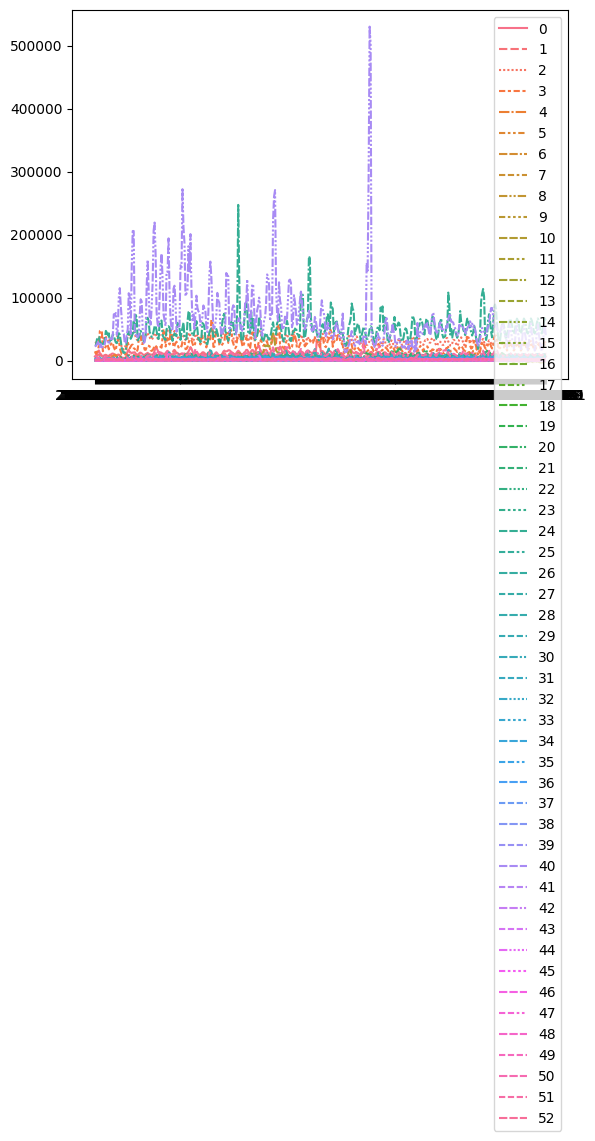

In [113]:
sell_per_Large = final.groupby(['소분류']).sum()[date]
sell_per_Large = sell_per_Large.reset_index()
display(sell_per_Large.head())
print(len(sell_per_Large))

name_large = sell_per_Large['소분류']
print(name_large)
temp = sell_per_Large.T.iloc[1:]
temp.head()

temp = temp.rename(columns=dict(zip(temp.columns, name_large)))

sns.lineplot(temp)

In [128]:
t= final[(final['대분류']==1)&(final['중분류']==4)&(final['소분류']==40)&(final['브랜드']==2440)]
t
# temp = t.T.iloc[1:]
# temp.head()

# temp = temp.rename(columns=dict(zip(temp.columns, name_large)))

# sns.lineplot(temp)

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-23,2023-03-24,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01
12332,1,4,40,2440,0,0,0,0,210,378,...,116.4306,45.6571,1.1714,-159.3235,-170.4330,-142.6967,-25.1603,94.3626,23.5891,-20.8967
12333,1,4,40,2440,0,0,0,0,0,0,...,-7.8348,1.1188,10.0010,-12.0182,-18.6461,-6.3891,36.9577,-7.7538,1.1998,10.0819
12334,1,4,40,2440,0,0,0,0,0,0,...,2553.1657,2819.5585,2601.4588,2523.5526,2417.5891,2417.8920,2494.6876,2618.4553,2884.8481,2666.7484
12335,1,4,40,2440,0,0,0,0,0,0,...,1945.1323,1833.2893,-998.8999,-1071.9747,-524.1332,-726.5955,180.6436,1807.6494,1695.8064,-1136.3829
12336,1,4,40,2440,378,378,252,126,378,630,...,3677.9892,4433.0600,-745.1051,-2983.4817,-3307.6951,-3724.6465,-1727.1414,3472.5106,4227.5813,-950.5837
12337,1,4,40,2440,792,540,624,540,960,1464,...,558.1287,586.3795,491.2092,392.0047,240.0056,288.0213,446.9036,540.0019,568.2527,473.0824
12338,1,4,40,2440,532,560,504,364,308,504,...,272.3343,298.4258,308.0395,284.6683,246.5527,193.7245,220.2342,278.2358,304.3273,313.9410
12339,1,4,40,2440,0,0,0,0,0,0,...,-1591.4898,-227.8897,-668.4032,-1312.3069,-2239.2892,-2804.5933,-2935.4701,-1746.8346,-383.2345,-823.7480
12340,1,4,40,2440,0,0,0,0,0,0,...,-771.3947,-246.8959,-1756.4278,-2393.8339,-2731.2586,-3365.0156,-1965.7035,-896.7808,-372.2821,-1881.8140
12341,1,4,40,2440,80,0,0,0,0,0,...,64.7334,133.1288,22.2879,-9.7771,-4.7344,36.3915,27.1130,64.7150,133.1104,22.2695


In [129]:
t[['2022-10-06', '2022-10-07', '2022-10-08']]

,2022-10-06,2022-10-07,2022-10-08
12332,0,0,0
12333,0,0,0
12334,0,0,0
12335,173450,164920,268
12336,200420,190398,0
12337,3558,4230,3924
12338,112,56,56
12339,92,92,184
12340,36,36,72
12341,0,0,0


In [132]:
t.iloc[:,275:290]

,2022-09-29,2022-09-30,2022-10-01,2022-10-02,2022-10-03,2022-10-04,2022-10-05,2022-10-06,2022-10-07,2022-10-08,2022-10-09,2022-10-10,2022-10-11,2022-10-12,2022-10-13
12332,3360,4032,1512,168,0,0,0,0,0,0,0,0,0,0,0
12333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12335,826,1082,1036,390,34956,30126,80026,173450,164920,268,138,138,302,92,302
12336,1712,1946,1646,726,43074,36920,96476,200420,190398,0,0,0,0,0,84
12337,3396,4380,4506,3738,2766,1818,2658,3558,4230,3924,3384,2568,2394,3450,4638
12338,140,168,280,196,112,112,112,112,56,56,168,196,84,0,56
12339,264,176,176,176,88,88,92,92,92,184,276,184,92,0,0
12340,108,180,240,96,96,0,36,36,36,72,36,36,36,132,132
12341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
final.iloc[:, 285:288] = final.iloc[:, 285:288].interpolate(method='linear', axis=1)

In [135]:
label_encoder.classes_[2440]

'B002-02920'